In [30]:
import lightgbm as lgb
from sklearn import metrics
import category_encoders as ce

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import time

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

# Defino funciones

In [31]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.score(test_features,test_labels)
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(predict*100))
    
    return predict

In [32]:
def imputar(df):
    imp = SimpleImputer()
    cols = df._get_numeric_data().columns
    df_result = df.copy()
    for x in cols:
        df_result[x]=imp.fit_transform(df[[x]])
    return df_result

In [34]:
def knn_best_distance(dist,x_train,y_train,x_test,y_test):
    primer_iter=True
    df = None
    for x in dist:
        print(x+" --------------------------")
        result = knn_predictor(x,x_train,y_train,x_test,y_test)
        if primer_iter:
            primer_iter = False
            df = pd.DataFrame(result)
        df[x] = pd.Series(result)
    return df

# Completo el data set

In [35]:
df = pd.read_csv('../data/train.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})

df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

df = df.drop(columns=["lat","lng","direccion","fecha","descripcion","titulo","idzona", 'gimnasio', 
                      'usosmultiples', 'piscina', 'escuelascercanas','garages',
                      'centroscomercialescercanos', 'dia'])

In [36]:
df1 = imputar(df)
imp = SimpleImputer(strategy="constant",fill_value="-")

df1["m2"]=(df1["metroscubiertos"]+df1["metrostotales"])

df_ids = df1["id"]
df1.drop(columns=["id"])

df1["tipodepropiedad"] = imp.fit_transform(df1[["tipodepropiedad"]])
df1["provincia"] = imp.fit_transform(df1[["provincia"]])
df1["ciudad"] = imp.fit_transform(df1[["ciudad"]])



In [37]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['ciudad', 'provincia', 'tipodepropiedad']

data_cols = df1._get_numeric_data().columns

baseline_data = df1[data_cols]

encoder = ce.CatBoostEncoder(cols=cat_features)
encoder.fit(df1[cat_features], df1['m2'])
encoded = encoder.transform(df1[cat_features]).transform(lambda x: x/100)
data = baseline_data.join(encoded)

In [54]:
x = data[data.columns.drop("precio")]
y = data['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print(f"Original shapes: X={x.shape} y={y.shape}")
print(f"Train shapes: X={x_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 12) y=(240000,)
Train shapes: X=(192000, 12) y=(192000,)
Test  shapes: X=(48000, 12)  y=(48000,)


In [55]:
transfo = x_train[["m2","metrostotales","metroscubiertos"]].transform(lambda x: np.log(x))
transfo["id"] = x_train["id"]

m2  metrostotales  metroscubiertos        id
129189  4.828314       4.094345         4.174387   90458.0
66416   5.732581       5.174822         4.882802  208135.0
230240  5.347108       4.499810         4.787492  153060.0
33120   5.802118       5.192957         5.017280    1384.0
234362  6.396930       5.703782         5.703782  176326.0
...          ...            ...              ...       ...
231801  5.225747       4.532599         4.532599   25457.0
22728   6.461468       5.799093         5.736572  270916.0
135094  6.322144       5.174822         5.940171  174850.0
125434  6.327937       5.298317         5.886104  291105.0
125753  6.429719       5.940171         5.480639  148251.0

[192000 rows x 4 columns]

In [56]:
x_train = x_train.drop(["m2","metrostotales","metroscubiertos"],axis=1)
x_train = pd.merge(transfo,x_train,how="inner",on="id")

# Pruebo

In [62]:
import Featurizer as ft
def knn_predictor(distancia,x_train,y_train,x_test,y_test):
    kesimos = []
    result = []
    for k in range(2000,2001):
        kesimos.append(k)
        knn = KNeighborsRegressor(n_neighbors = k, metric=distancia)
        knn.fit(x_train, y_train)
        res = ft.predecir(knn,x_train,y_train,x_test,y_test)
        result.append(res)
    return {'x':kesimos, distancia:result}

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

dists = [
"euclidean",
"manhattan",
"chebyshev"]

start_time = time.time()
dist = knn_best_distance(dists,x_train,y_train,x_test,y_test)
print("--- %s seconds ---" % (time.time() - start_time))

euclidean --------------------------


In [177]:
prueba.drop(columns="Kactual",inplace=True)

(30, -0.1)

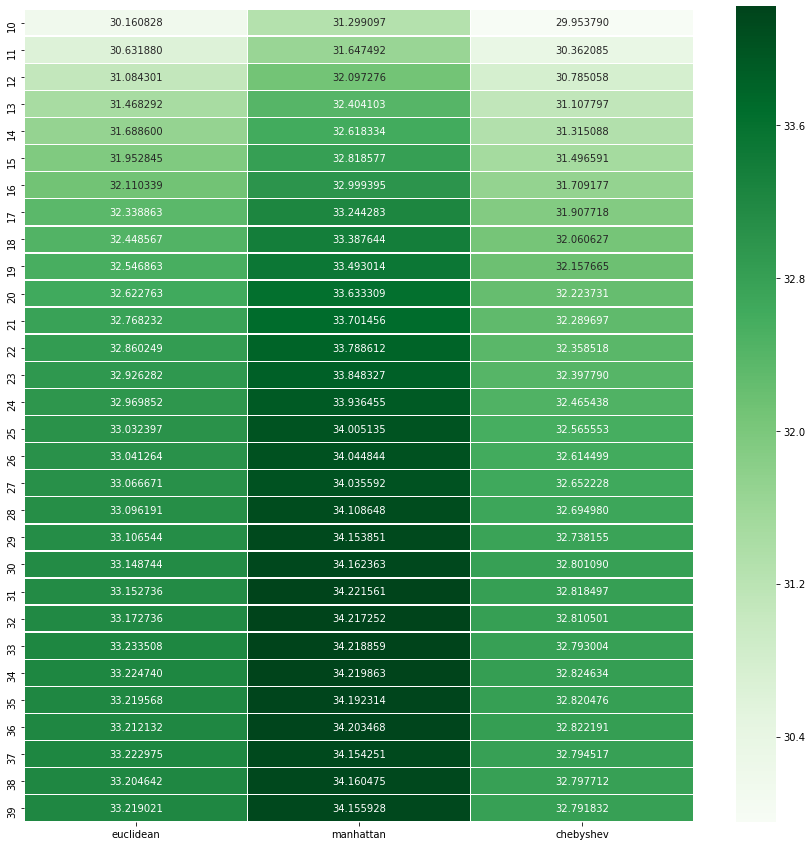

In [180]:
a= prueba.transform(lambda x: x*100)
plt.figure(figsize=(15, 15))

sns.heatmap(a, annot=True, fmt='.6f', linewidths=.5,cmap="Greens").set_ylim(30,-0.1)

In [179]:
knn = KNeighborsRegressor(n_neighbors =35, metric="manhattan")

knn.fit(x_train, y_train)

res = predecir(knn,x_train,y_train,x_test,y_test)

Entrenamiento: 37.4082%
Testeo: 34.1923%.


# Result de test

In [164]:
#Resultado de test
knn = KNeighborsRegressor(n_neighbors = 36, metric="manhattan")

#Entreno con todo el dataset
knn.fit(x, y)

#Predigo la data
predict = knn.predict(data)

In [165]:
result = df_ids.astype("int32").to_frame()
result["target"] = predict.astype("int32")

In [166]:
result = df_ids.astype("int32").to_frame()
result["target"] = predict.astype("int32")
result.to_csv("../data/results/resultKNN.csv", index=False)

In [107]:
result.head()

id   target
0    4941  3477325
1   51775   839491
2  115253  1693631
3  299321  1240362
4  173570   930956